# **Experiments on synthetic data**
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lealagonotte/Geometric_data_analysis_project/blob/raph-colab/experiments/main_synthetic.ipynb)  
See on Hugging Face: https://huggingface.co/datasets/xingjiepan/PerturbMulti

## **Colab setup**

In [ ]:
!git clone https://github.com/lealagonotte/Geometric_data_analysis_project.git
%cd Geometric_data_analysis_project/
!git clone https://github.com/raphaelrubrice/Perturb-OT.git
!git checkout raph-colab

In [ ]:
!pip install -r requirements-env.txt

YOU WILL NEED TO RESTART THE SESSION AFTER THE PREVIOUS CELL.
After restarting you should have a working env.

Let's check that we have succesfully recreated the env

In [ ]:
import sys

from perturbot.match import (
    get_coupling_cotl, 
    get_coupling_cotl_sinkhorn, 
    get_coupling_egw_labels_ott,
    get_coupling_egw_all_ott,
    get_coupling_eot_ott,
    get_coupling_leot_ott,
    get_coupling_egw_ott,
    get_coupling_cot, 
    get_coupling_cot_sinkhorn, 
    get_coupling_gw_labels,
    get_coupling_fot,
)
from perturbot.predict import train_mlp
import ot
print("Imports succeeded")

## **Imports**

In [20]:
import torch
import perturbot.match
import perturbot.predict
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
from perturbot.eval.prediction import get_evals, get_evals_preds
from perturbot.eval.match import get_FOSCTTM_single, get_FOSCTTM
import ot
import time

## **Generate data according to Appendix G from [Ryu et al., 2024](https://arxiv.org/abs/2405.00838)**

In [21]:
## Generate synthetic data as specified in Annex G

def generate_synthetic_data(n_cells_per_pert=50, n_perturbations=10, d_latent=5, p_X=50, p_Y=200):
    """Generate synthetic data as specified in Annex G """
    print(f"Generation of {n_cells_per_pert * n_perturbations} synthetic cells")
    n_total_cells = n_cells_per_pert * n_perturbations

    # Z ~ N(0, 0.1)
    Z_base = np.random.normal(0.0, np.sqrt(0.1), (n_total_cells, d_latent))

    # A_X, A_Y, b_X, b_Y, s_X, s_Y
    A_X = np.random.normal(0.0, 1.0, (d_latent, p_X))
    A_Y = np.random.normal(0.0, 1.0, (d_latent, p_Y))
    b_X = np.random.normal(0.0, 1.0, (p_X,))
    b_Y = np.random.normal(0.0, 1.0, (p_Y,))
    s_X = np.random.gamma(1.0, 1.0, (p_X,))
    s_Y = np.random.gamma(1.0, 1.0, (p_Y,))

    # zeta_X, zeta_Y (Technical noise)
    std_X = np.sqrt(np.exp(np.random.normal(-3, 0)))
    zeta_X = np.random.normal(0, std_X, (n_total_cells, d_latent))
    std_Y = np.sqrt(np.exp(np.random.normal(-3, 0)))
    zeta_Y = np.random.normal(0, std_Y, (n_total_cells, d_latent))

    # Labels and perturbation
    labels = np.repeat(np.arange(n_perturbations), n_cells_per_pert)
    target_dims = np.zeros(n_perturbations, dtype=int)
    target_dims[1:] = (np.arange(n_perturbations - 1) % d_latent)
    effect_sizes = np.zeros(n_perturbations)
    effect_sizes[1:] = np.maximum(3.0, np.random.gamma(1.0, 1.0, n_perturbations - 1))
    penetrance = np.random.beta(1.0, 10.0, n_total_cells) 

    Z_perturbed = Z_base.copy()
    for i in range(n_total_cells):
        label_idx = labels[i]
        if label_idx > 0: # No perturbation for label 0
            target_dim = target_dims[label_idx]
            effect = effect_sizes[label_idx]
            Z_perturbed[i, target_dim] += effect * penetrance[i]

    # Final Generation
    Z_noisy_X = Z_perturbed + zeta_X
    Z_noisy_Y = Z_perturbed + zeta_Y
    X = ((Z_noisy_X @ A_X) + b_X) * s_X
    Y = ((Z_noisy_Y @ A_Y) + b_Y) * s_Y

    # Identifier of the cells
    ids = np.arange(n_total_cells).reshape(-1, 1)

    return X, Y, labels, ids

In [22]:
#We generate the data as presented in Annex G
X_full, Y_full, labels_full, ids_full = generate_synthetic_data(
        n_cells_per_pert=50, 
        n_perturbations=10, 
        d_latent=5, 
        p_X=50, 
        p_Y=200
    )

Generation of 500 synthetic cells


In [23]:
def format_data_for_coupling(X, Y, labels):
    """
    Transform the data into dictionaries keyed by integer labels.
    """
    X_dict = {}
    Y_dict = {}
    unique_labels = np.unique(labels)
    
    for l_numpy in unique_labels:
        l_python = int(l_numpy) 
        
        indices = np.where(labels == l_numpy)[0]

        X_dict[l_python] = X[indices]
        Y_dict[l_python] = Y[indices]
        
    return (X_dict, Y_dict)

In [24]:
# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test, lab_train, lab_test = train_test_split(
    X_full, 
    Y_full, 
    labels_full, 
    test_size=0.2,
    random_state=3,
    stratify=labels_full
)

In [25]:
# Format the data for coupling
data_train = format_data_for_coupling(X_train, Y_train, lab_train)
data_test = format_data_for_coupling(X_test, Y_test, lab_test)

#Grund truth test set preparation
unique_labels_test = sorted(data_test[0].keys()) 
X_test = np.concatenate([data_test[0][l] for l in unique_labels_test], axis=0)
X_test_t = torch.tensor(X_test, dtype=torch.double)
Y_test_concatenated = np.concatenate([data_test[1][l] for l in unique_labels_test], axis=0)

unique_labels_train = sorted(data_train[0].keys())
labels_train = np.concatenate([
    np.full(len(data_train[0][l]), l) for l in unique_labels_train
])

## **Compute couplings with diverse methods**
(GWOT, COOT, FGWOT, with or without labels, with or without entropic regularization)

In [ ]:
#EGWOT labeled
legw = perturbot.match.get_coupling_egw_labels_ott(
        data_train,
        eps=0.001  
    )

In [ ]:
#EGWOT without labels
egw = perturbot.match.get_coupling_egw_all_ott(
        data_train,
        eps=0.005 
    )

In [ ]:
#EGWOT per labels
egwper = perturbot.match.get_coupling_egw_ott(
        data_train,
        eps=0.050
    )

In [ ]:
#COOT labeled
cotl= perturbot.match.get_coupling_cotl(
        data_train,
    )

In [ ]:
#ECOOT labeled
ecotl = perturbot.match.get_coupling_cotl_sinkhorn(
        data_train,
        eps=1e-2  
    )

In [ ]:
#COOT without labels
cot=    perturbot.match.get_coupling_cot(
        data_train,
    )

In [ ]:
#ECOOT without labels
ecot = perturbot.match.get_coupling_cot_sinkhorn(
        data_train,
        eps=0.500 
    )

In [ ]:
#Fused GW
def get_coupling_fused_gw(X_train, Y_train, labels_train, epsilon=0.001, alpha=0.99, max_iter=500):
    """
    Compute the Fused Gromov-Wasserstein coupling between X_train and Y_train
    using labels_train for the fused cost.
    """
    # -----------------------------
    # 1. Matrices de coût C1 et C2
    # -----------------------------
    # Calcul des matrices de coût quadratiques normalisées
    C1 = ot.dist(X_train, X_train, metric='euclidean')**2
    C2 = ot.dist(Y_train, Y_train, metric='euclidean')**2
    C1=C1/C1.max()
    C2=C2/C2.max()

    # -----------------------------
    # 2. Matrice de coût fused M
    # -----------------------------
    # Ici M[i,j] = 1 si labels différents, 0 sinon
    start = time.time()
    n_train = X_train.shape[0]
    m_train = Y_train.shape[0]
    labels_X = labels_train[:, np.newaxis]  # shape (n_train, 1)
    labels_Y = labels_train[np.newaxis, :]  # shape (1, m_train)

    # M = 1 si labels différents
    M = (labels_X != labels_Y).astype(float)

    print("Calcul du transport plan Fused Gromov-Wasserstein (alpha=1 -> GW uniquement)...")
    T = ot.gromov.entropic_fused_gromov_wasserstein(
        M, C1, C2, alpha=alpha, epsilon=epsilon, max_iter=max_iter, verbose=True
    ) 
    end= time.time()
    runtime = end - start
    return T, {"time": runtime}
fgw= get_coupling_fused_gw(X_train, Y_train, labels_train, epsilon=0.001, alpha=0.99, max_iter=500)

running EGWL with ott
GW called
lse step
updating linearization
Label considered for Sinkhorn run
lse step
updating linearization
Label considered for Sinkhorn run
5 outer iterations were needed.
The last Sinkhorn iteration has converged: True
The outer loop of Gromov Wasserstein has converged: True
The final regularized GW cost is: 0.291
Done running LEGWOT with ott
running EGWOT with ott
GW called
lse step
updating linearization
lse step
updating linearization
5 outer iterations were needed.
The last Sinkhorn iteration has converged: True
The outer loop of Gromov Wasserstein has converged: True
The final regularized GW cost is: 0.010
Done running EGWOT with ott
GW called
lse step
updating linearization
lse step
updating linearization
GW called
lse step
updating linearization
lse step
updating linearization
GW called
lse step
updating linearization
lse step
updating linearization
GW called
lse step
updating linearization
lse step
updating linearization
GW called
lse step
updating line

NameError: name 'time' is not defined

## **Train MLP to evaluate performances on obtained couplings**

In [27]:
#We train the MLP models for each coupling and evaluate their performance on the test set compared with the Ground Truth

couplings = [legw, egw, egwper, cotl, ecotl, cot, ecot, fgw]
coupling_names = [
    "EGWOT Labeled (legw)", 
    "EGWOT All (egw)", 
    "EGWOT Per Label (egwper)", 
    "COOT Labeled (cotl)", 
    "ECOOT Labeled (ecotl)", 
    "COOT All (cot)", 
    "ECOOT All (ecot)",
    "Fused GW (fgw)"
]

results_pred = []

print("\n Evaluation of the prediction models")

for i, coupling in enumerate(couplings):
    coupling_name = coupling_names[i]
    coupling_for_train = coupling[0]
    time_for_train = coupling[1]
    model, pred_log = perturbot.predict.train_mlp(data_train, coupling_for_train)

    model.eval()
    with torch.no_grad():
        Y_pred = model(X_test_t).cpu().numpy().astype(np.float64)

    
    Y_test_concatenated = Y_test_concatenated.astype(np.float64)
    metrics_df_pred= get_evals_preds(
        Y_test_concatenated,  # Y_true (Grund Truth)
        [Y_pred],              
        pred_labels=[coupling_name], 
        full=False
       
    )    

    metrics_dict = metrics_df_pred[coupling_name].to_dict() 
    metrics_dict["method"] = coupling_name 
    metrics_dict["time"] = time_for_train
    results_pred.append(metrics_dict)


    print(f"[{i+1}/{len(couplings)}] {coupling_name}: "
          f"MSE={metrics_dict.get('MSE', np.nan):.4f}, "
          f"Pearson={metrics_dict.get('Pearson_corr', np.nan):.4f}")


results_df = pd.DataFrame(results_pred)
print("\nSummary Table of Prediction Metrics")
print(results_df)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 15.5 K
  | other params | n/a        | 200   
--------------------------------------------
15.7 K    Trainable params
0         Non-trainable params
15.7 K    Total params
0.063     Total estimated model params size (MB)



 Evaluation of the prediction models
INFO     Running sanity check on val set...                                                                        


c:\Users\leala\Documents\mva\geometric data analysis\test2\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\leala\Documents\mva\geometric data analysis\test2\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\leala\Documents\mva\geometric data analysis\test2\.venv\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:293: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoc

Epoch 165/2000:   8%|▊         | 165/2000 [00:07<01:21, 22.42it/s, v_num=283, train_loss_epoch=1.4] 
Monitored metric val_loss did not improve in the last 45 records. Best score: 0.983. Signaling Trainer to stop.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[1/8] EGWOT Labeled (legw): MSE=1.3261, Pearson=0.8252



  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 15.5 K
  | other params | n/a        | 200   
--------------------------------------------
15.7 K    Trainable params
0         Non-trainable params
15.7 K    Total params
0.063     Total estimated model params size (MB)


INFO     Running sanity check on val set...                                                                        


c:\Users\leala\Documents\mva\geometric data analysis\test2\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\leala\Documents\mva\geometric data analysis\test2\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\leala\Documents\mva\geometric data analysis\test2\.venv\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:293: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoc

Epoch 179/2000:   9%|▉         | 179/2000 [00:07<01:13, 24.62it/s, v_num=284, train_loss_epoch=1.43]
Monitored metric val_loss did not improve in the last 45 records. Best score: 0.971. Signaling Trainer to stop.
[2/8] EGWOT All (egw): MSE=1.4451, Pearson=0.8054

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 15.5 K
  | other params | n/a        | 200   
--------------------------------------------
15.7 K    Trainable params
0         Non-trainable params
15.7 K    Total params
0.063     Total estimated model params size (MB)



INFO     Running sanity check on val set...                                                                        


c:\Users\leala\Documents\mva\geometric data analysis\test2\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\leala\Documents\mva\geometric data analysis\test2\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\leala\Documents\mva\geometric data analysis\test2\.venv\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:293: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoc

Epoch 171/2000:   9%|▊         | 171/2000 [00:06<01:14, 24.53it/s, v_num=285, train_loss_epoch=1.55]
Monitored metric val_loss did not improve in the last 45 records. Best score: 1.131. Signaling Trainer to stop.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[3/8] EGWOT Per Label (egwper): MSE=1.3545, Pearson=0.8186



  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 15.5 K
  | other params | n/a        | 200   
--------------------------------------------
15.7 K    Trainable params
0         Non-trainable params
15.7 K    Total params
0.063     Total estimated model params size (MB)


INFO     Running sanity check on val set...                                                                        


c:\Users\leala\Documents\mva\geometric data analysis\test2\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\leala\Documents\mva\geometric data analysis\test2\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\leala\Documents\mva\geometric data analysis\test2\.venv\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:293: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoc

Epoch 141/2000:   7%|▋         | 141/2000 [00:05<01:18, 23.69it/s, v_num=286, train_loss_epoch=1.19]
Monitored metric val_loss did not improve in the last 45 records. Best score: 1.579. Signaling Trainer to stop.
[4/8] COOT Labeled (cotl): MSE=1.3793, Pearson=0.8159

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 15.5 K
  | other params | n/a        | 200   
--------------------------------------------
15.7 K    Trainable params
0         Non-trainable params
15.7 K    Total params
0.063     Total estimated model params size (MB)



INFO     Running sanity check on val set...                                                                        


c:\Users\leala\Documents\mva\geometric data analysis\test2\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\leala\Documents\mva\geometric data analysis\test2\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\leala\Documents\mva\geometric data analysis\test2\.venv\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:293: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoc

Epoch 150/2000:   8%|▊         | 150/2000 [00:06<01:23, 22.27it/s, v_num=287, train_loss_epoch=1.38]
Monitored metric val_loss did not improve in the last 45 records. Best score: 1.186. Signaling Trainer to stop.
[5/8] ECOOT Labeled (ecotl): MSE=1.3724, Pearson=0.8191

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 15.5 K
  | other params | n/a        | 200   
--------------------------------------------
15.7 K    Trainable params
0         Non-trainable params
15.7 K    Total params
0.063     Total estimated model params size (MB)


INFO     Running sanity check on val set...                                                                        


c:\Users\leala\Documents\mva\geometric data analysis\test2\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\leala\Documents\mva\geometric data analysis\test2\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\leala\Documents\mva\geometric data analysis\test2\.venv\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:293: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoc

Epoch 149/2000:   7%|▋         | 149/2000 [00:06<01:15, 24.66it/s, v_num=288, train_loss_epoch=1.18]
Monitored metric val_loss did not improve in the last 45 records. Best score: 1.968. Signaling Trainer to stop.
[6/8] COOT All (cot): MSE=1.5860, Pearson=0.7891


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 15.5 K
  | other params | n/a        | 200   
--------------------------------------------
15.7 K    Trainable params
0         Non-trainable params
15.7 K    Total params
0.063     Total estimated model params size (MB)


INFO     Running sanity check on val set...                                                                        


c:\Users\leala\Documents\mva\geometric data analysis\test2\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\leala\Documents\mva\geometric data analysis\test2\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\leala\Documents\mva\geometric data analysis\test2\.venv\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:293: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoc

Epoch 162/2000:   8%|▊         | 162/2000 [00:06<01:12, 25.19it/s, v_num=289, train_loss_epoch=1.51]
Monitored metric val_loss did not improve in the last 45 records. Best score: 1.049. Signaling Trainer to stop.
[7/8] ECOOT All (ecot): MSE=1.4497, Pearson=0.8039

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 15.5 K
  | other params | n/a        | 200   
--------------------------------------------
15.7 K    Trainable params
0         Non-trainable params
15.7 K    Total params
0.063     Total estimated model params size (MB)



INFO     Running sanity check on val set...                                                                        


c:\Users\leala\Documents\mva\geometric data analysis\test2\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\leala\Documents\mva\geometric data analysis\test2\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\leala\Documents\mva\geometric data analysis\test2\.venv\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:293: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoc

Epoch 147/2000:   7%|▋         | 147/2000 [00:05<01:14, 24.89it/s, v_num=290, train_loss_epoch=1.52]
Monitored metric val_loss did not improve in the last 45 records. Best score: 1.092. Signaling Trainer to stop.
[8/8] Fused GW (fgw): MSE=1.3708, Pearson=0.8173

Summary Table of Prediction Metrics
   Pearson_corr  Spearman_corr  Pearson_samples  Spearman_samples       MSE  \
0      0.825223       0.735827         0.264901          0.255810  1.326148   
1      0.805368       0.706677         0.010852          0.005252  1.445051   
2      0.818581       0.725384         0.245116          0.235863  1.354478   
3      0.815897       0.712296         0.181166          0.177356  1.379345   
4      0.819108       0.725570         0.215208          0.194749  1.372351   
5      0.789100       0.681699         0.044833          0.038849  1.585952   
6      0.803905       0.704447         0.031693          0.031770  1.449667   
7      0.817265       0.720477         0.187241          0.181036  1.

In [28]:
print("Evaluation of coupling metrics on the training data")
#Metrics evaluation on the training set

Xs_train_dict = data_train[0]
Xt_train_dict = data_train[1]

labeled_couplings = [legw, cotl, ecotl] 
labeled_coupling_names = [
    "EGWOT Labeled (legw)",
    "COOT Labeled (cotl)",
    "ECOOT Labeled (ecotl)"
]
global_couplings = [egw, cot, ecot, fgw]
global_coupling_names = [
    "EGWOT Global (egw)",
    "COOT Global (cot)",
    "ECOOT Global (ecot)",
    "Fused GW (fgw)"
]

results_match = []
#Labeled couplings
for i, coupling in enumerate(labeled_couplings):
    coupling_name = labeled_coupling_names[i]
    T_dict = coupling[0] 

    #Bary FSTTM (Barycentre FOSCTTM: use_barycenter=True)
    foscttm_bary_list, median_foscttm_bary = get_FOSCTTM(
        T_dict=T_dict, Xs_dict=Xs_train_dict, Xt_dict=Xt_train_dict, use_barycenter=True
    )
    
    all_foscttm_bary = foscttm_bary_list
    mean_foscttm_bary = np.nanmean(all_foscttm_bary)

    results_match.append({
        "method": coupling_name,
        "Bary_FOSCTTM": median_foscttm_bary, 
        "Mean_Bary_FOSCTTM": mean_foscttm_bary,
    })

#Global couplings
for i, coupling in enumerate(global_couplings):
    coupling_name = global_coupling_names[i]
    T = coupling[0]
    
    foscttm_bary_list, median_foscttm_bary = get_FOSCTTM_single(
        T=T, Xs_dict=Xs_train_dict, Xt_dict=Xt_train_dict, use_barycenter=True
    )
    
    all_foscttm_bary = foscttm_bary_list
    mean_foscttm_bary = np.nanmean(all_foscttm_bary)   

    results_match.append({
        "method": coupling_name,
        "Bary_FOSCTTM": median_foscttm_bary, 

        "Mean_Bary_FOSCTTM": mean_foscttm_bary,

    })

results_match_df = pd.DataFrame(results_match)
print("\nSummary Table of Coupling Metrics (Training Set)")
print(results_match_df)

Evaluation of coupling metrics on the training data

Summary Table of Coupling Metrics (Training Set)
                  method  Bary_FOSCTTM  Mean_Bary_FOSCTTM
0   EGWOT Labeled (legw)      0.409179           0.409179
1    COOT Labeled (cotl)      0.395226           0.395226
2  ECOOT Labeled (ecotl)      0.418089           0.418089
3     EGWOT Global (egw)      0.497494           0.498690
4      COOT Global (cot)      0.456140           0.475827
5    ECOOT Global (ecot)      0.500000           0.500006
6         Fused GW (fgw)      0.409774           0.429204


## **Computation times**

In [29]:
# Time information for the couplings

for index, log_dict in results_df['time'].items():
    if isinstance(log_dict, dict):
        print(f"Ligne {index} - Clés : {list(log_dict.keys())}")
    else:
        print(f"Ligne {index} - Ce n'est pas un dictionnaire : {type(log_dict)}")
        
def extract_total_time(log_dict):
    if 'time' in log_dict:
        return log_dict['time']
    total_time = 0
    found_time = False
    for key, val in log_dict.items():
        if isinstance(val, dict) and 'time' in val:
            total_time += val['time']
            found_time = True
            
    if found_time:
        return total_time
        
    return None

results_df['extracted_time'] = results_df['time'].apply(extract_total_time)

print(results_df[['method', 'extracted_time']])

Ligne 0 - Clés : ['n_iters_outer', 'converged_inner', 'converged_outer', 'GW cost', 'time', 'cost_time']
Ligne 1 - Clés : ['n_iters_outer', 'converged_inner', 'converged_outer', 'GW cost', 'time', 'cost_time']
Ligne 2 - Clés : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Ligne 3 - Clés : ['cost', 'time']
Ligne 4 - Clés : ['cost', 'time']
Ligne 5 - Clés : ['cost', 'time']
Ligne 6 - Clés : ['cost', 'time']
Ligne 7 - Clés : ['time']
                     method  extracted_time
0      EGWOT Labeled (legw)        5.137381
1           EGWOT All (egw)        1.241335
2  EGWOT Per Label (egwper)       11.075976
3       COOT Labeled (cotl)        0.082223
4     ECOOT Labeled (ecotl)      862.022956
5            COOT All (cot)       28.742317
6          ECOOT All (ecot)        6.379194
7            Fused GW (fgw)       15.008515


## **Coupling matrices visualization**

Visualization of Coupling Matrices
VISUALIZATION OF LABELED COUPLING (Label 0)


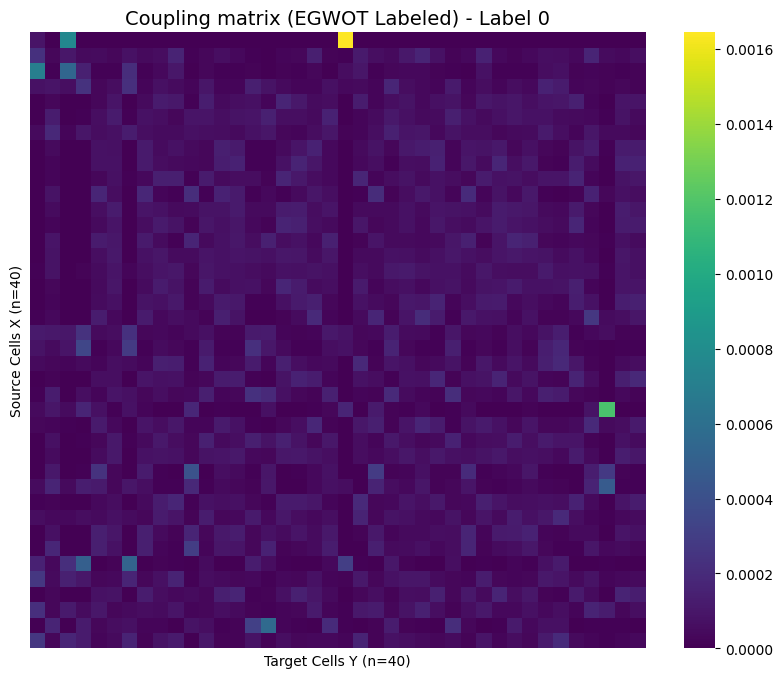

------------------------------


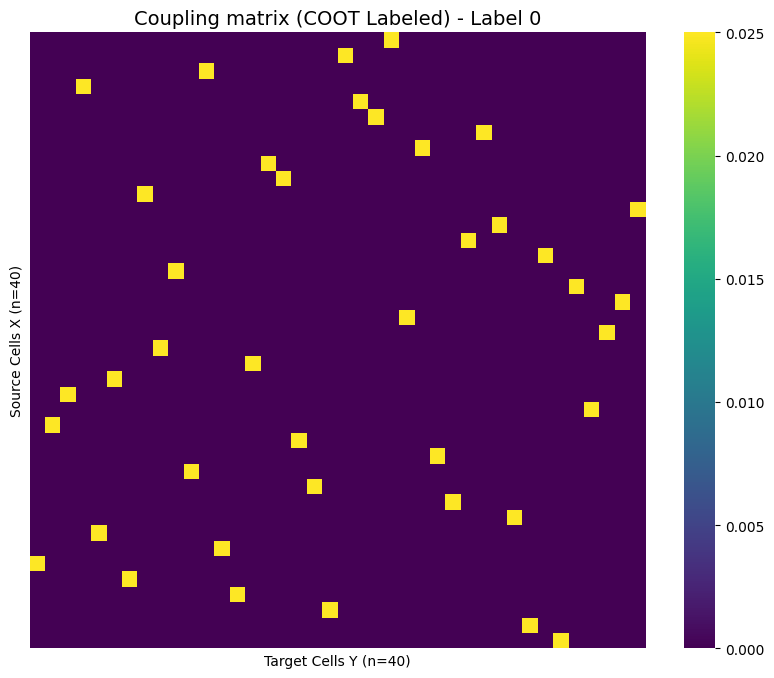

------------------------------


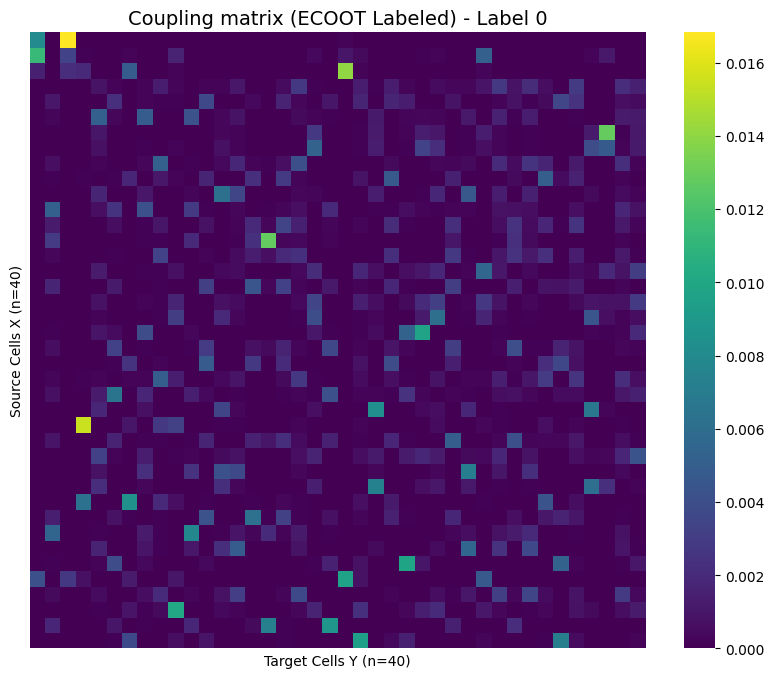

------------------------------
VISUALIZATION OF LABELED COUPLING (Label 1)


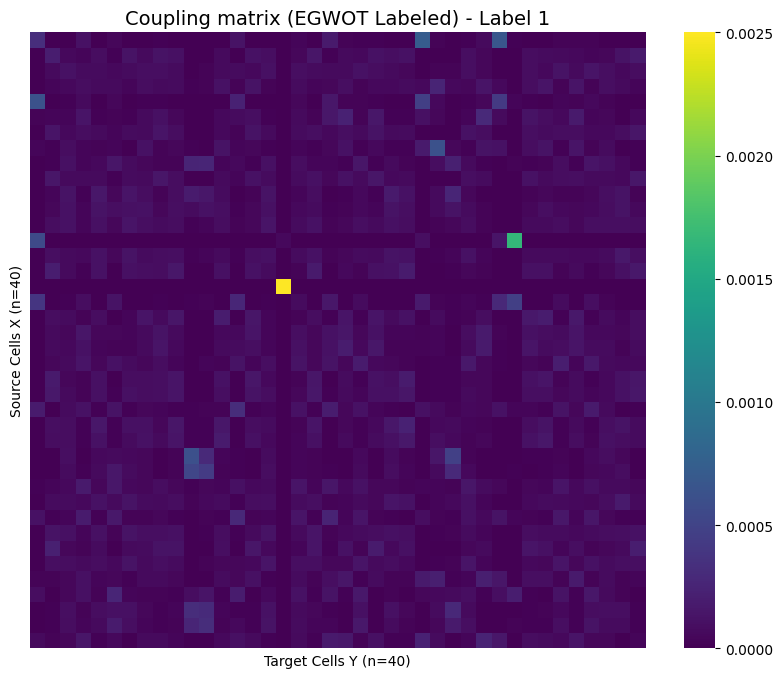

------------------------------


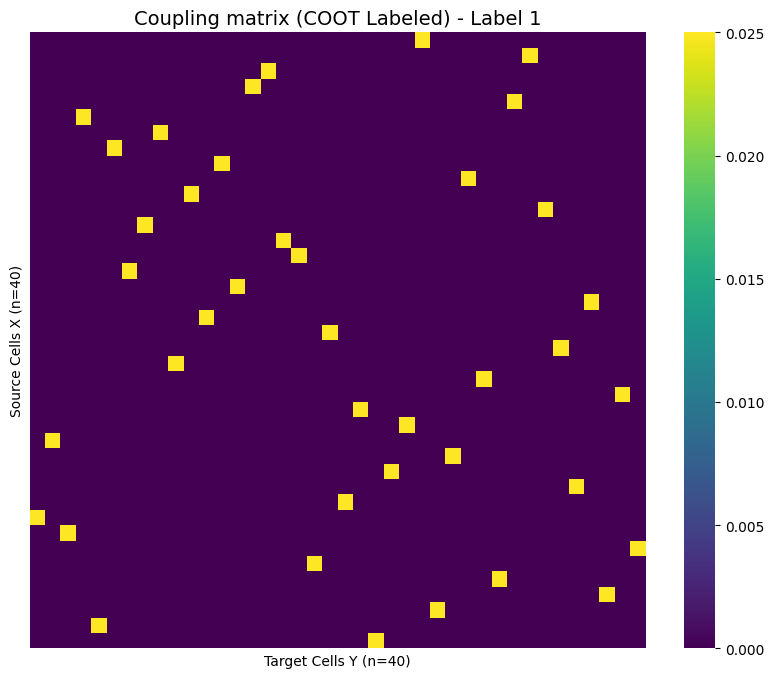

------------------------------


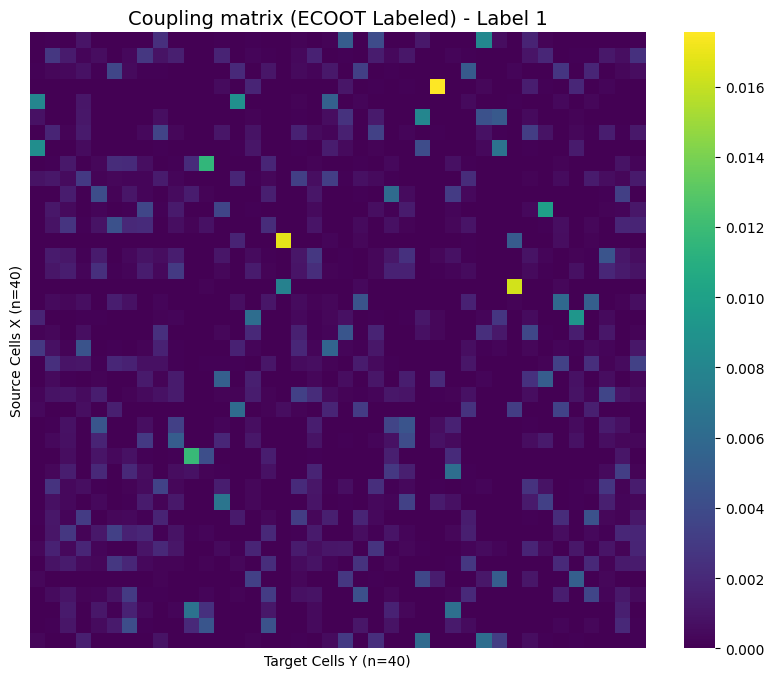

------------------------------
VISUALIZATION OF LABELED COUPLING (Label 2)


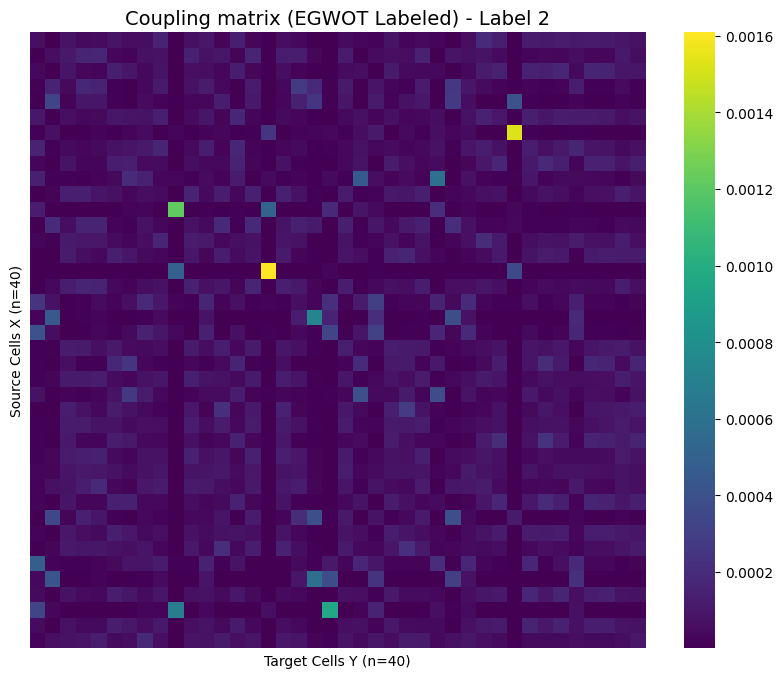

------------------------------


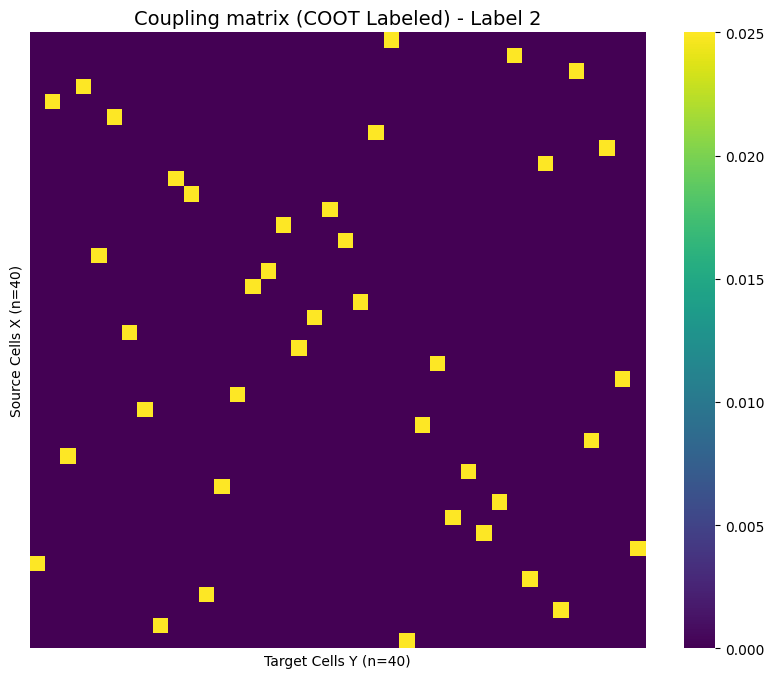

------------------------------


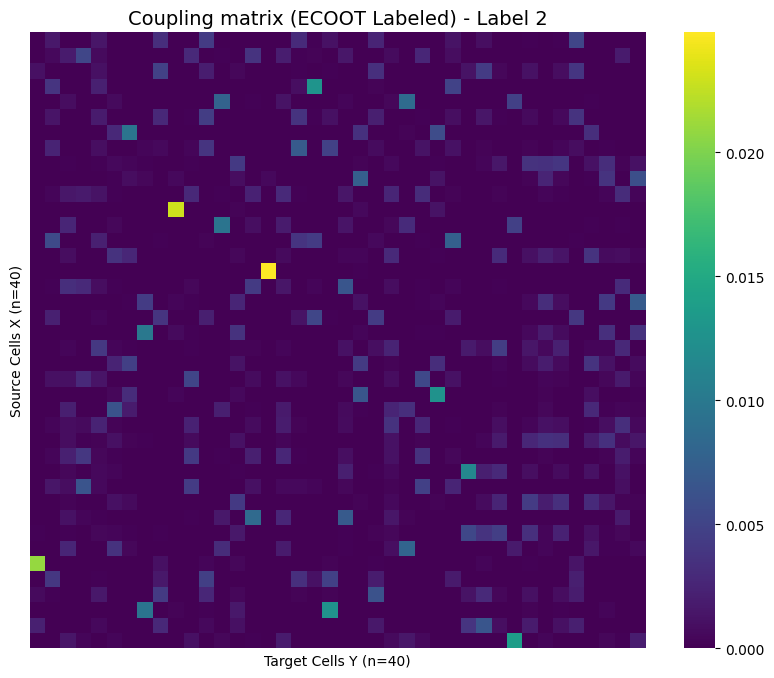

------------------------------
VISUALIZATION OF LABELED COUPLING (Label 3)


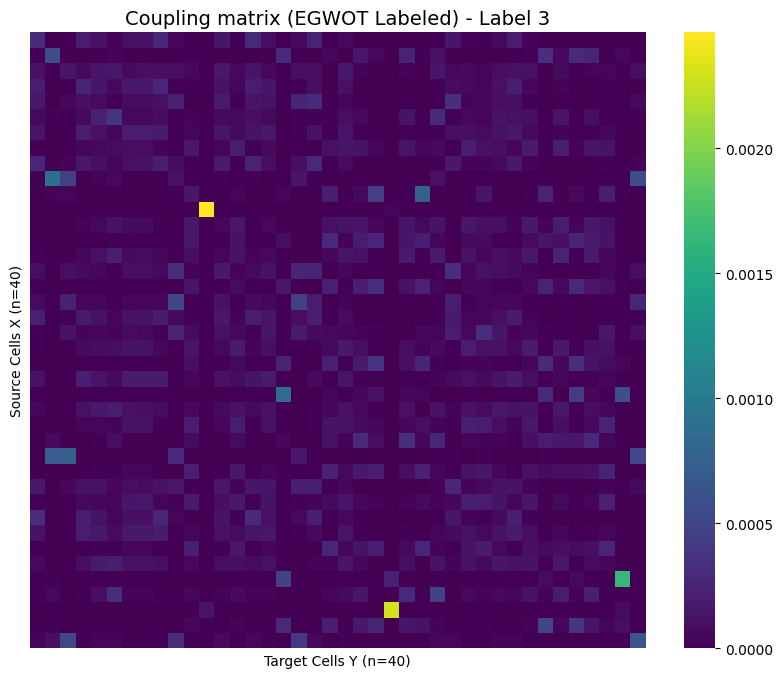

------------------------------


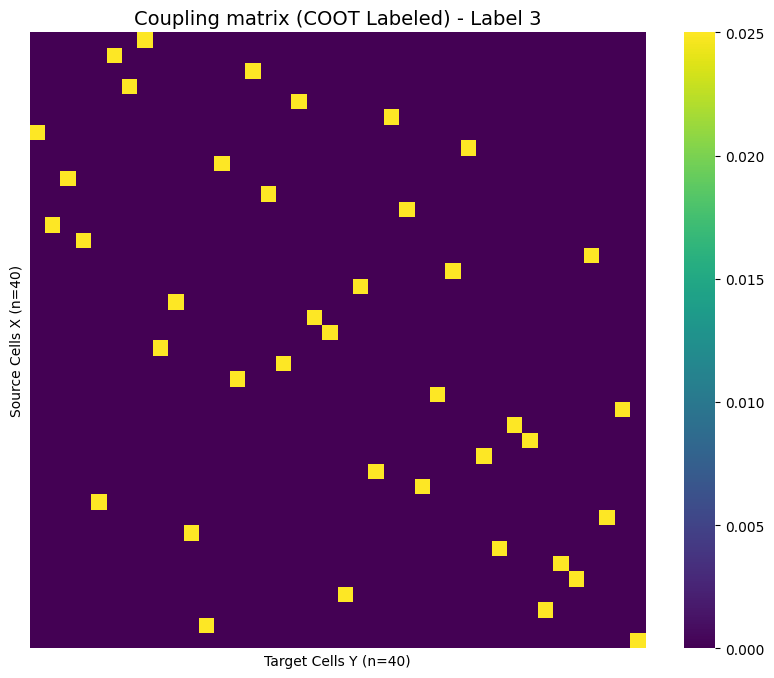

------------------------------


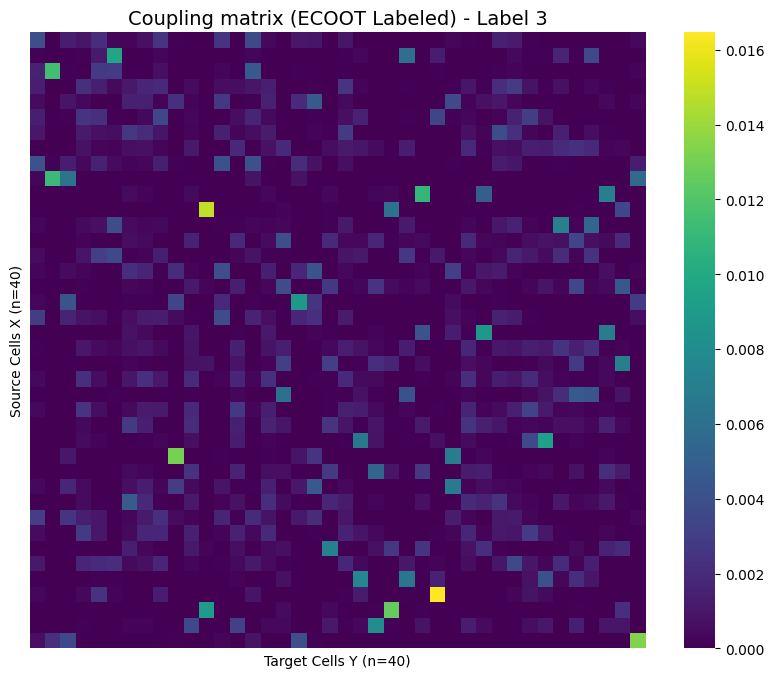

------------------------------
VISUALIZATION OF LABELED COUPLING (Label 4)


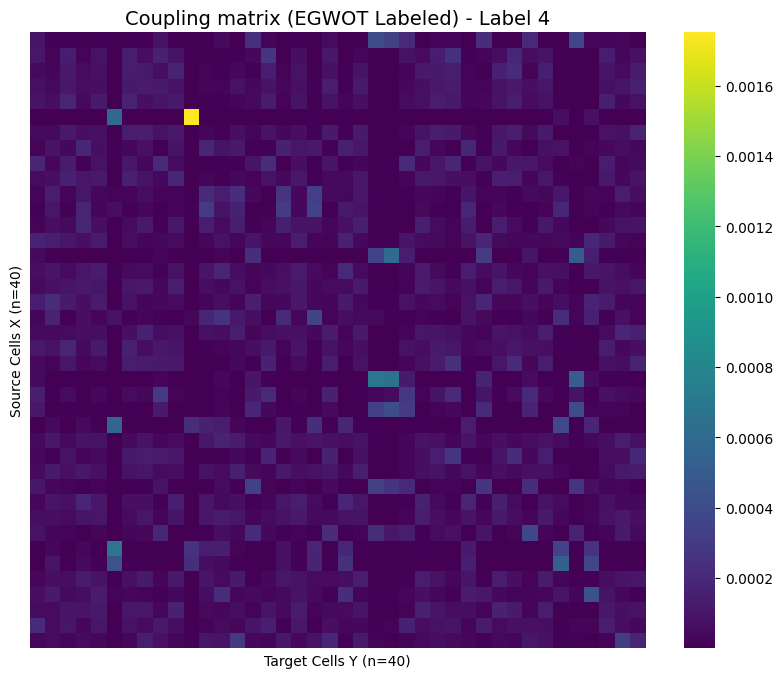

------------------------------


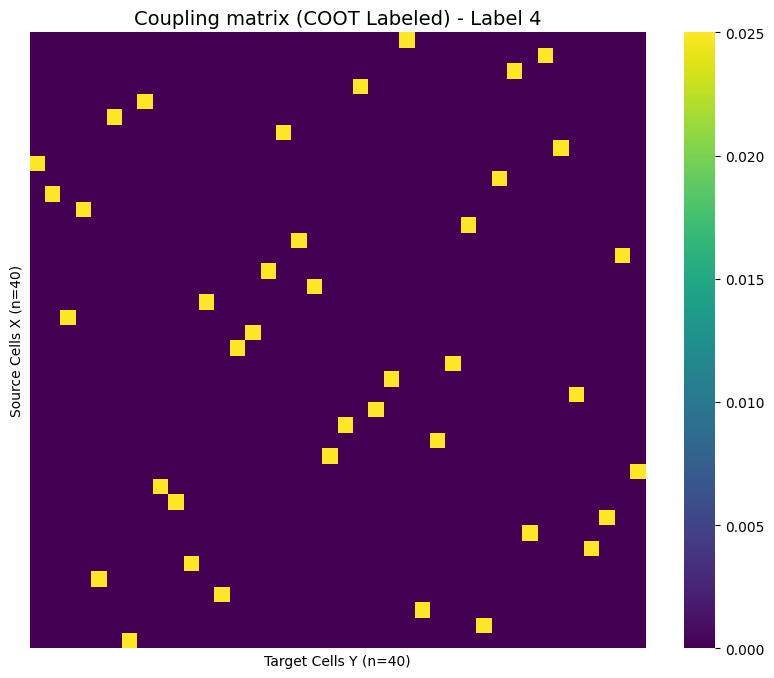

------------------------------


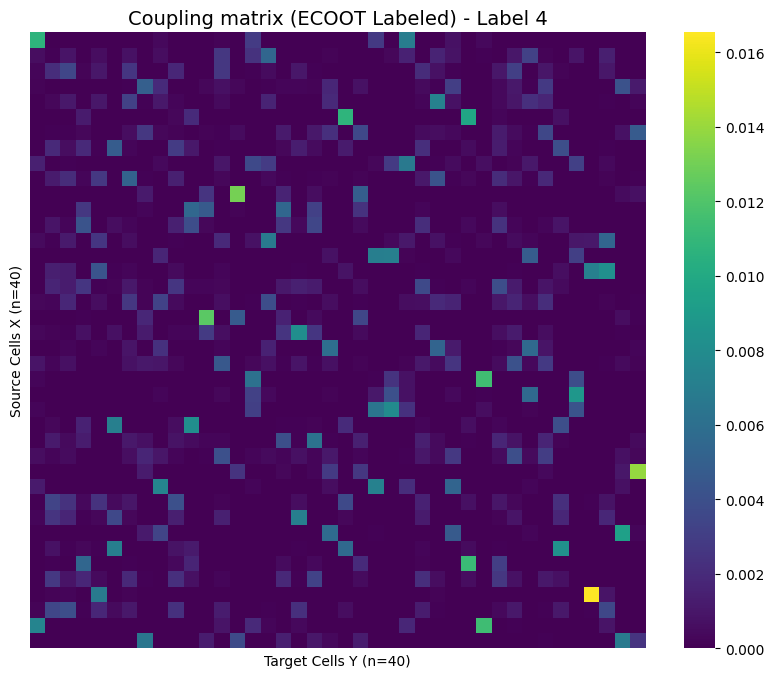

------------------------------
VISUALIZATION OF LABELED COUPLING (Label 5)


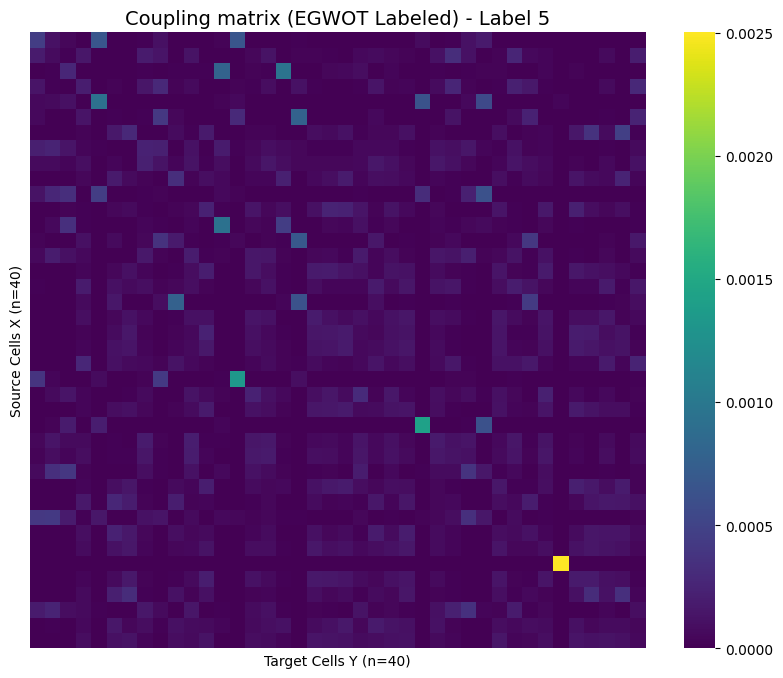

------------------------------


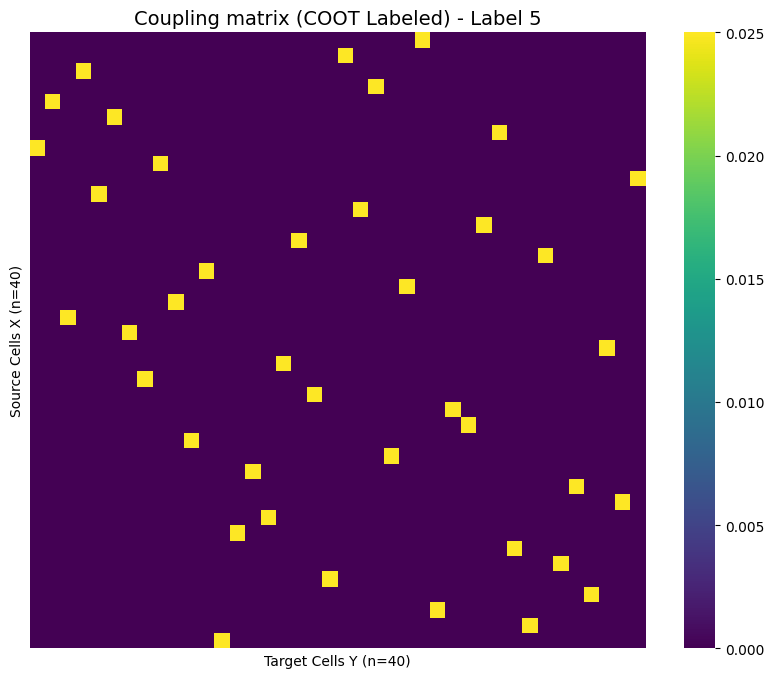

------------------------------


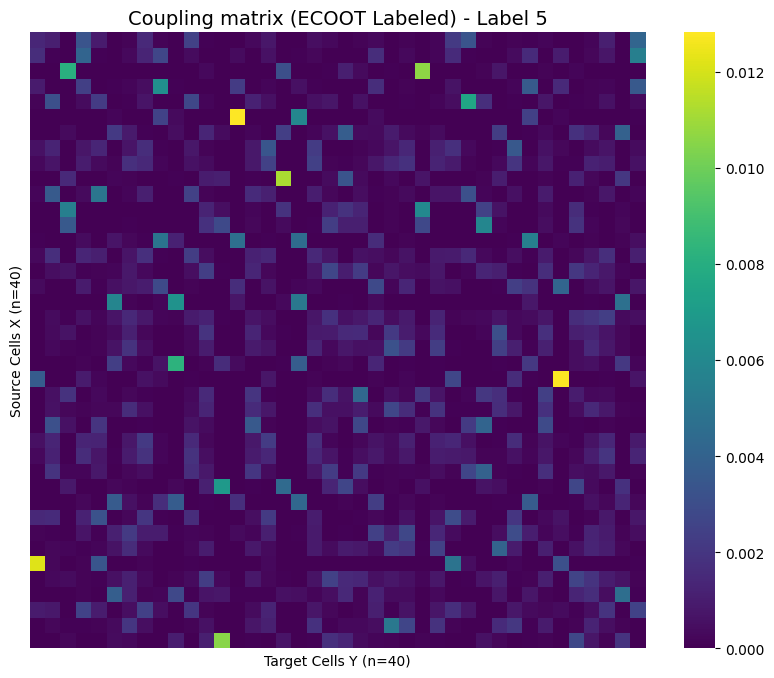

------------------------------
VISUALIZATION OF LABELED COUPLING (Label 6)


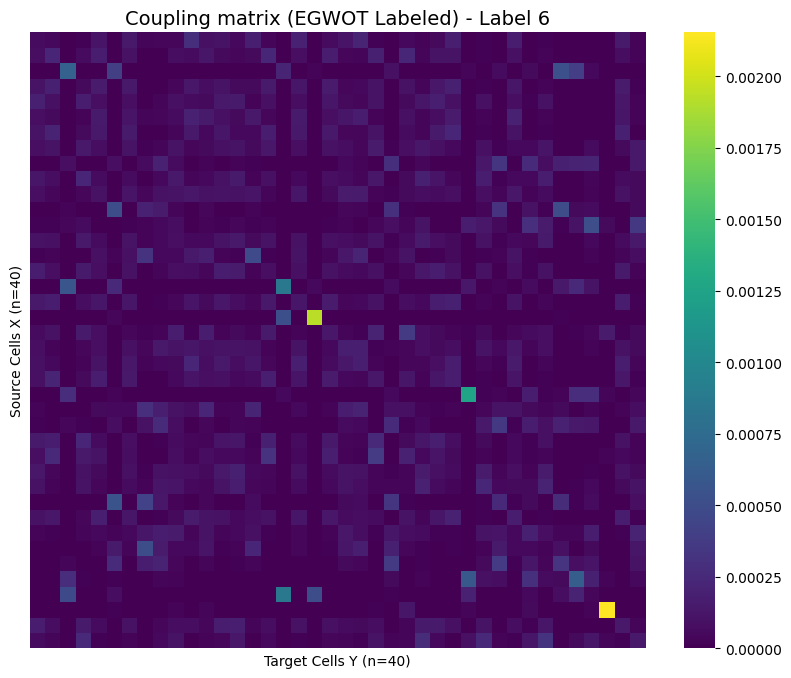

------------------------------


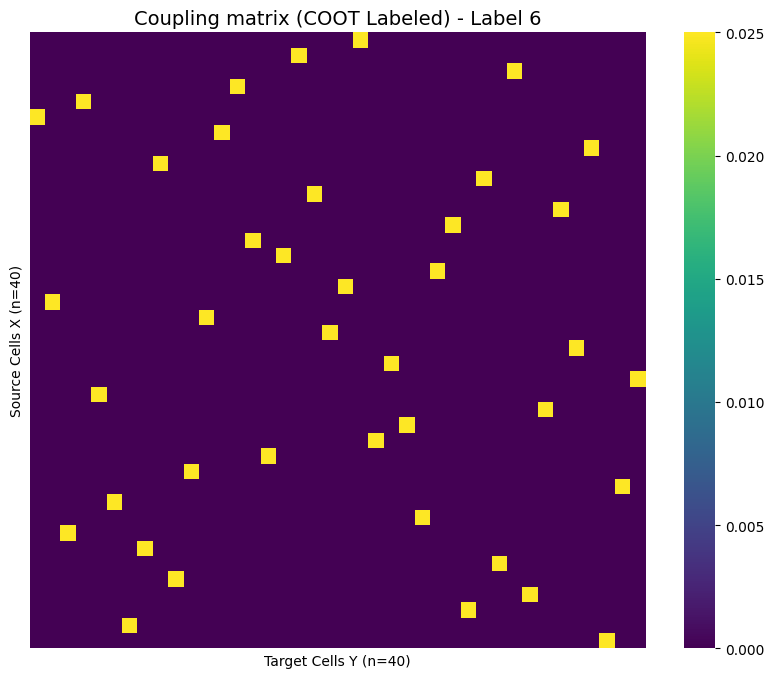

------------------------------


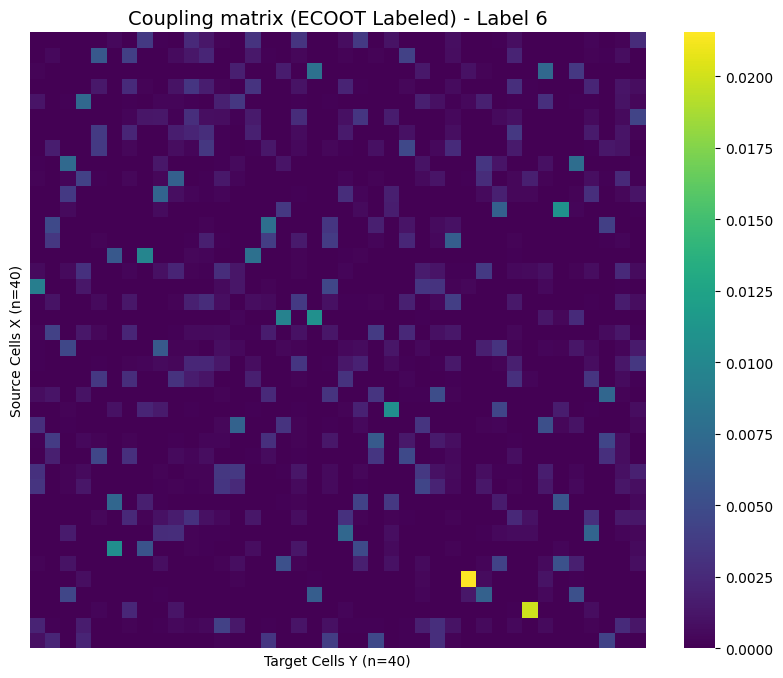

------------------------------
VISUALIZATION OF LABELED COUPLING (Label 7)


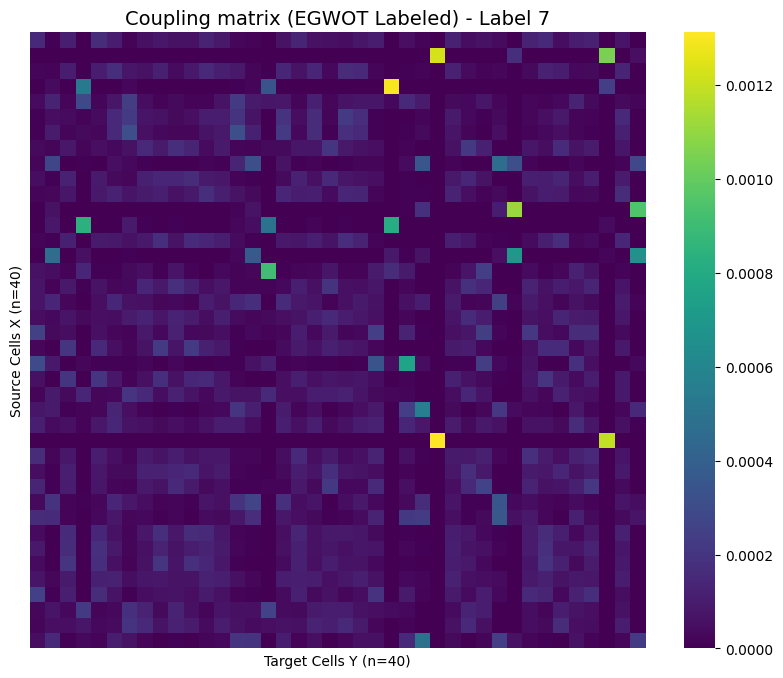

------------------------------


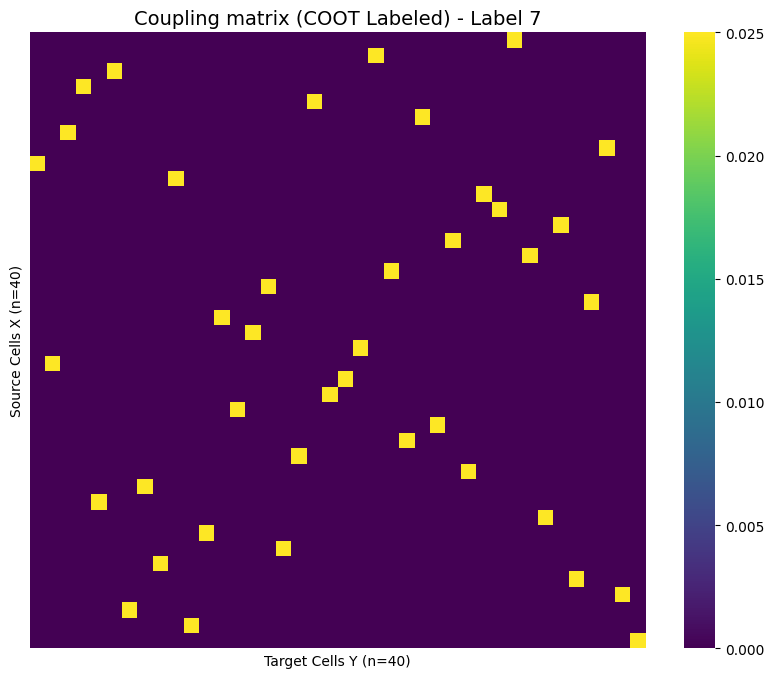

------------------------------


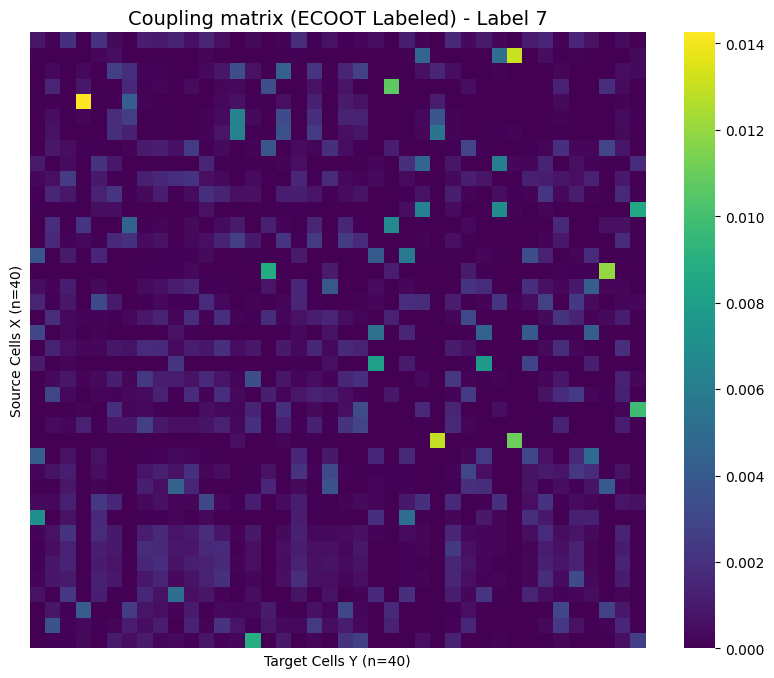

------------------------------
VISUALIZATION OF LABELED COUPLING (Label 8)


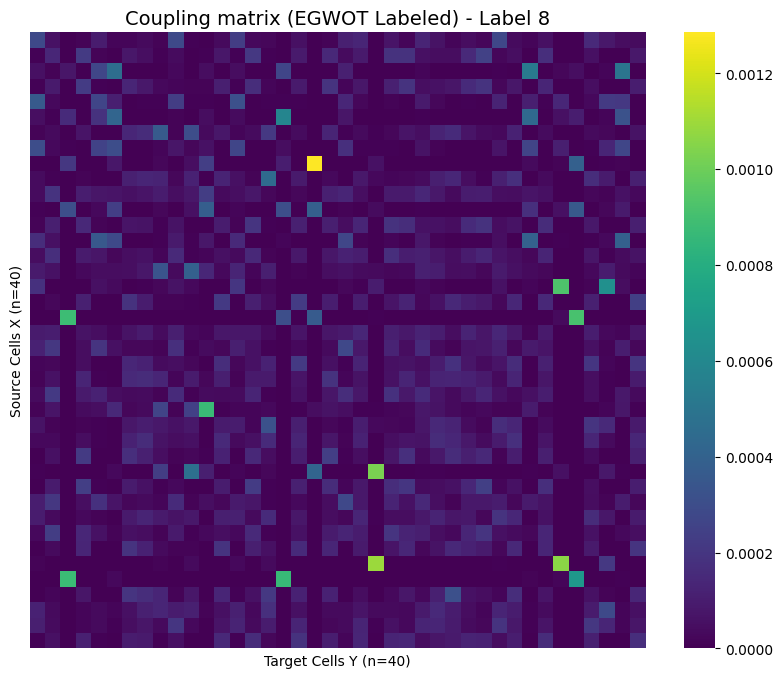

------------------------------


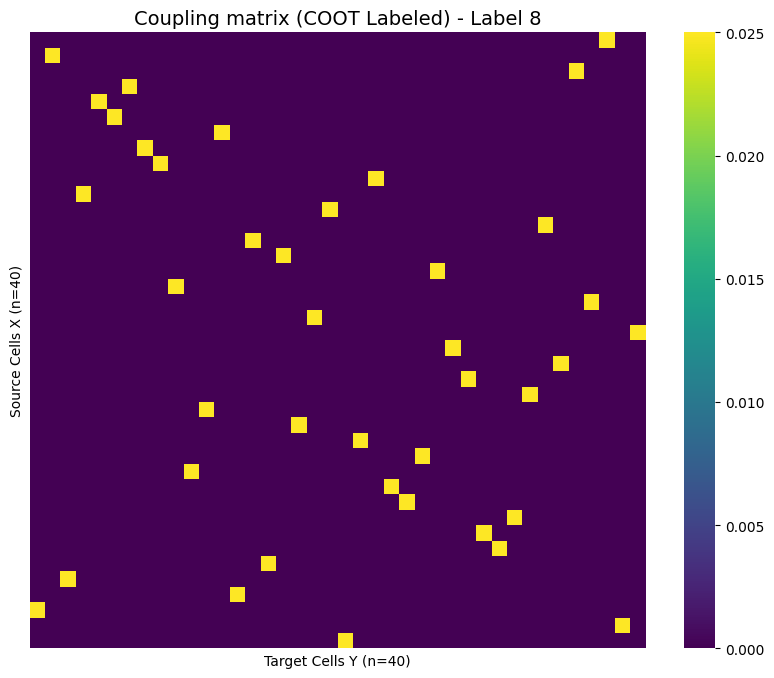

------------------------------


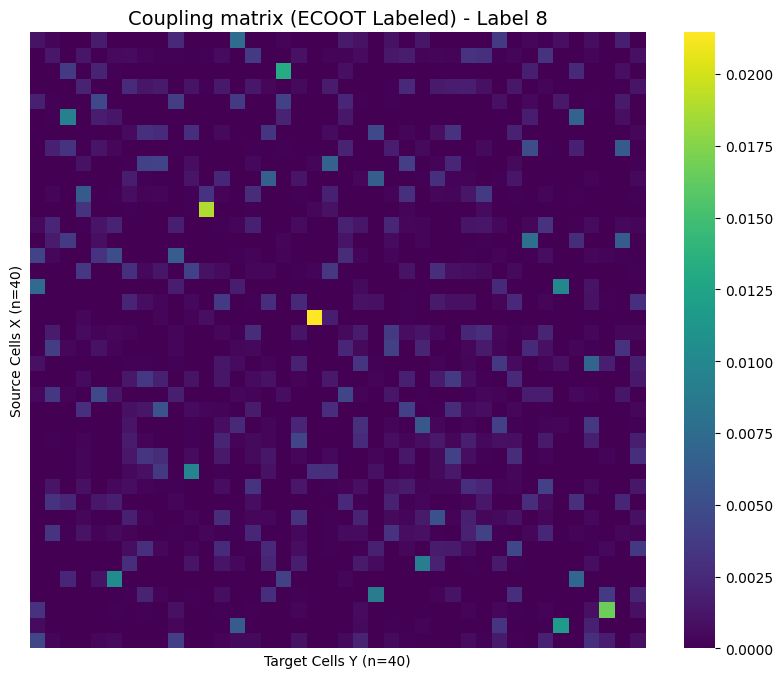

------------------------------
VISUALIZATION OF LABELED COUPLING (Label 9)


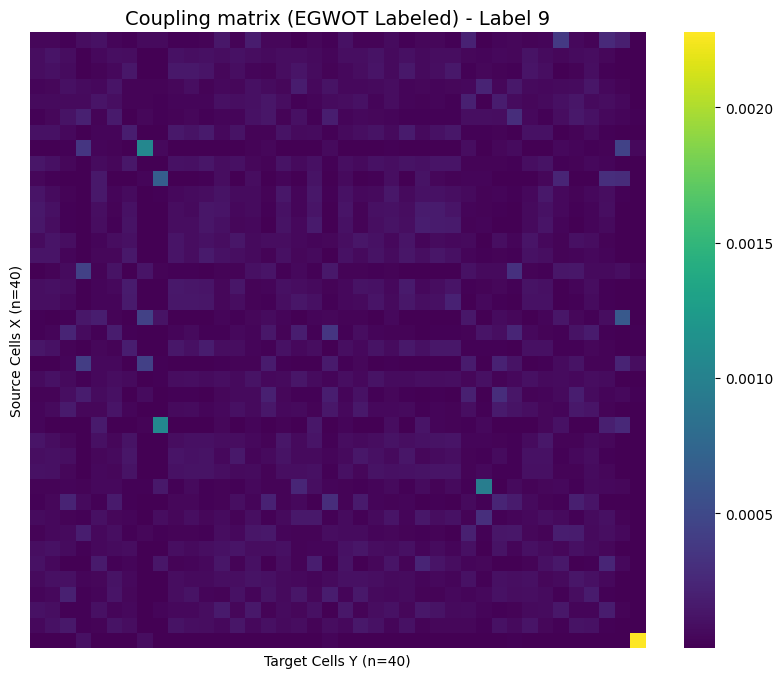

------------------------------


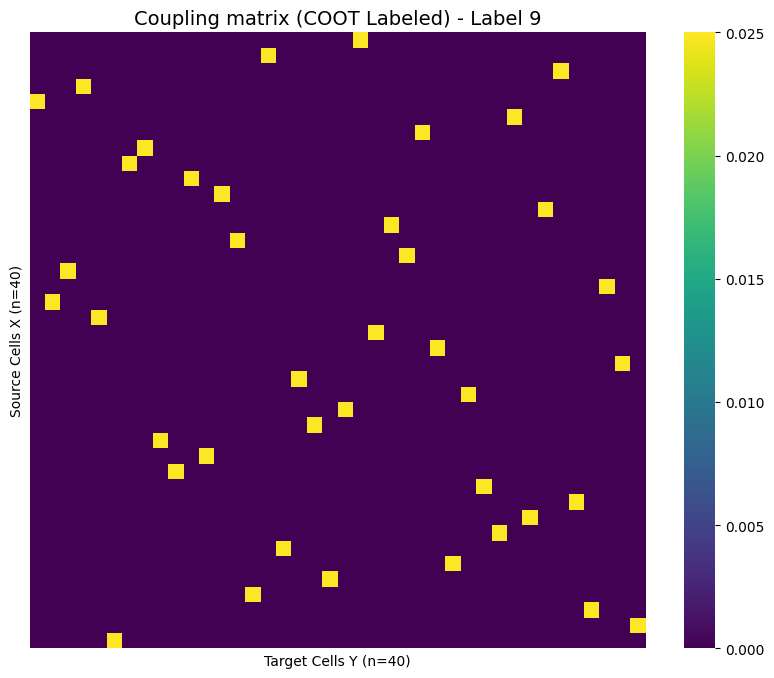

------------------------------


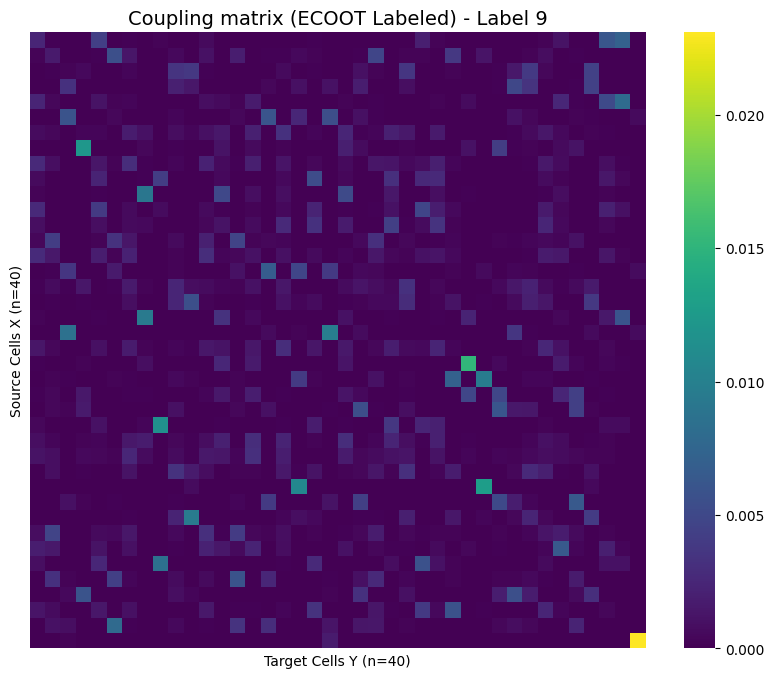

------------------------------
VISUALIZATION OF AGGREGATED COUPLING (Single Matrix) 


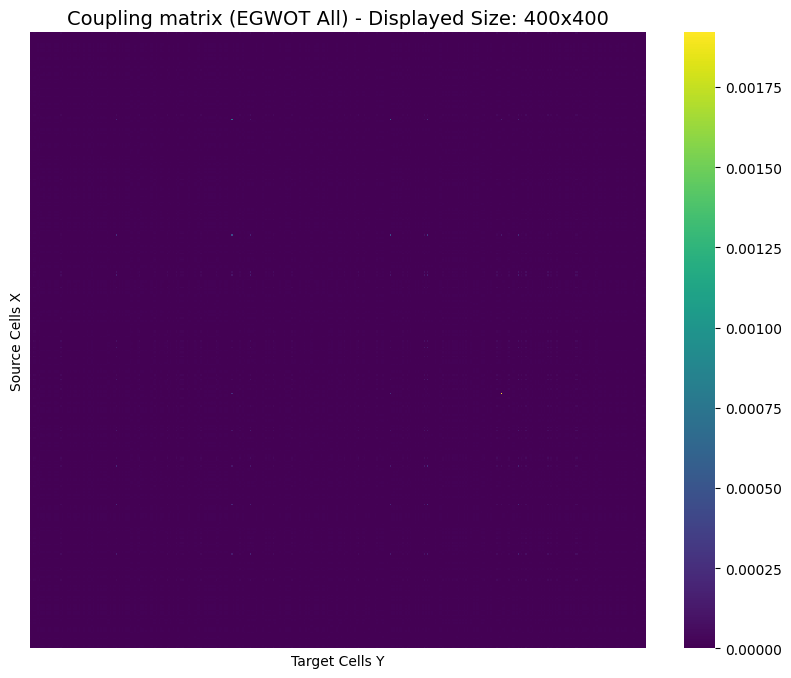

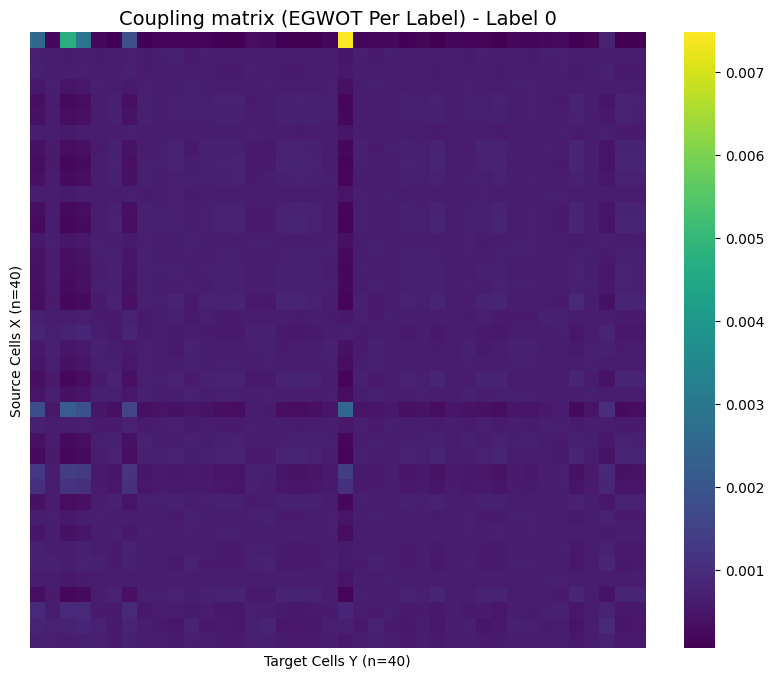

------------------------------


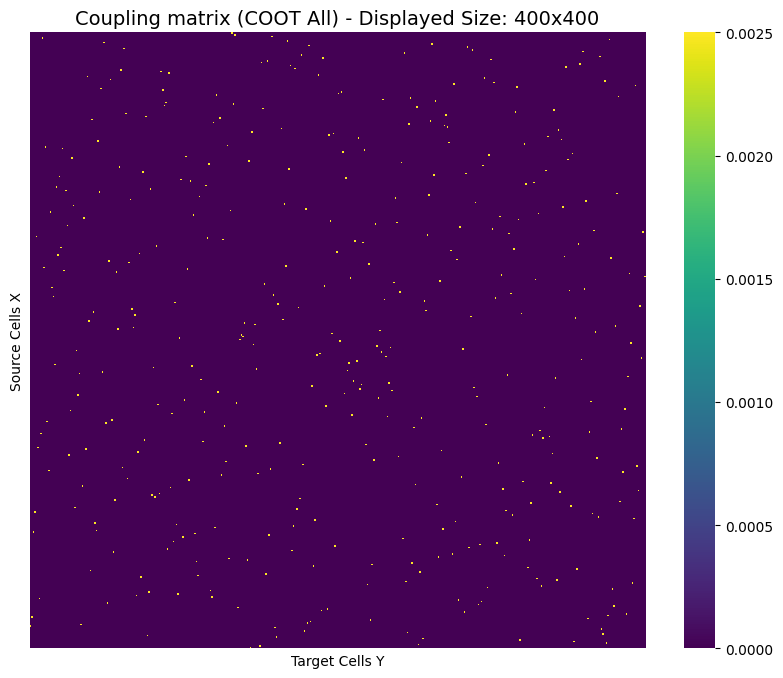

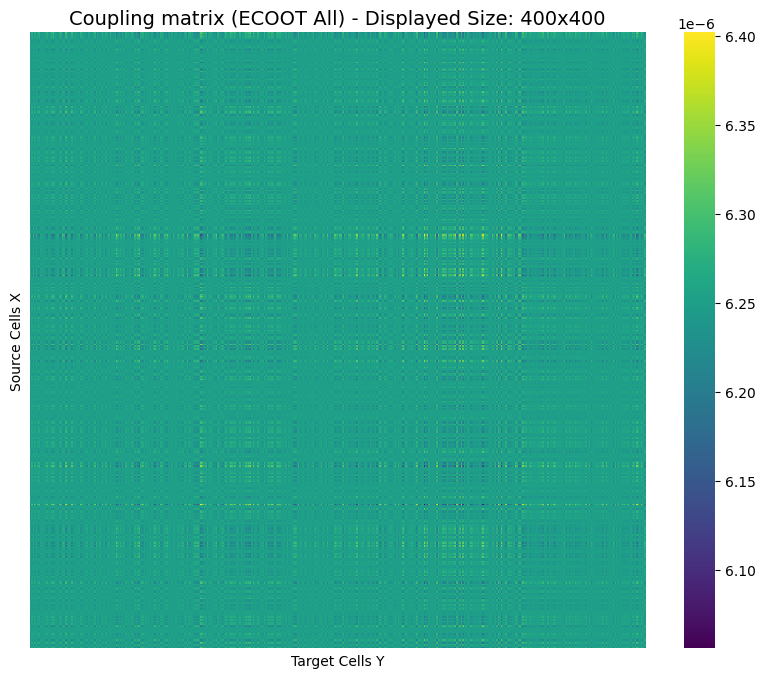

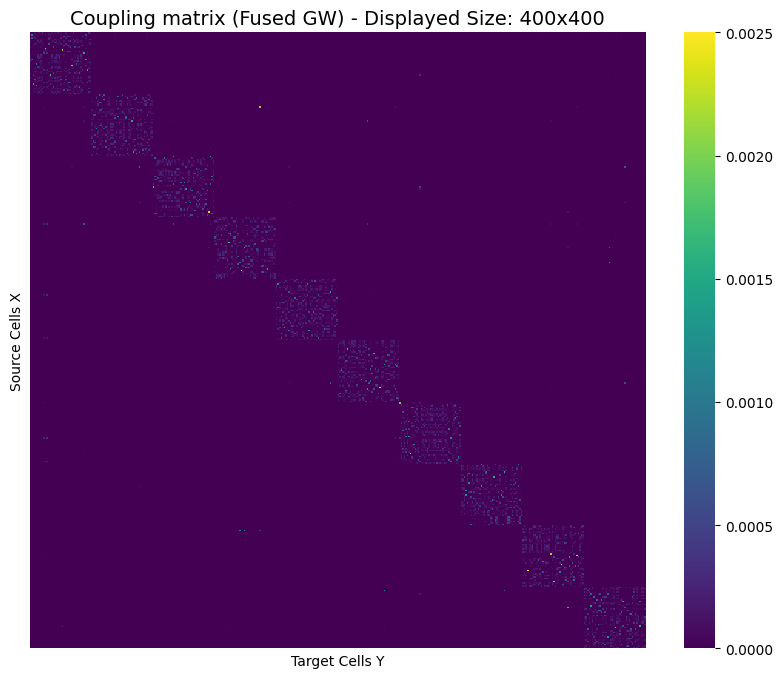

In [30]:
print("Visualization of Coupling Matrices")

def plot_coupling_heatmap(lgw_tuple, method_name, label_to_plot=0):
    """
    Display the transport matrix for a given label (for labeled methods).

    """

    couplings_dict = lgw_tuple[0]

    P = couplings_dict[label_to_plot]    

    if hasattr(P, 'cpu'): 
        P = P.cpu().numpy()

    plt.figure(figsize=(10, 8))
    
    sns.heatmap(
        P, 
        cmap="viridis", 
        cbar=True, 
        xticklabels=False, 
        yticklabels=False,
        square=True 
    )
    
    plt.title(f"Coupling matrix ({method_name}) - Label {label_to_plot}", fontsize=14)
    plt.xlabel(f"Target Cells Y (n={P.shape[1]})")
    plt.ylabel(f"Source Cells X (n={P.shape[0]})")
    plt.show()

    print("-" * 30)

def plot_single_coupling_matrix(coupling_tuple, method_name):
    """
    Display the full transport matrix (for unlabeled or aggregated methods).
    """
    P = coupling_tuple[0]

    if hasattr(P, 'cpu'): 
        P = P.cpu().numpy()

    display_size = min(P.shape[0], 500)
    M_display = P[:display_size, :display_size]

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        M_display, 
        cmap="viridis", 
        cbar=True, 
        xticklabels=False, 
        yticklabels=False,
        square=True
    )
    
    plt.title(
        f"Coupling matrix ({method_name}) - Displayed Size: {M_display.shape[0]}x{M_display.shape[1]}", 
        fontsize=14
    )
    plt.xlabel(f"Target Cells Y")
    plt.ylabel(f"Source Cells X")
    plt.show()


# Execution of the Visualization
for i in np.unique(labels_full):
    print(f"VISUALIZATION OF LABELED COUPLING (Label {i})")
    # Display for labeled methods (which return a Dictionary)
    plot_coupling_heatmap(legw, "EGWOT Labeled", label_to_plot=i)
    plot_coupling_heatmap(cotl, "COOT Labeled", label_to_plot=i)
    plot_coupling_heatmap(ecotl, "ECOOT Labeled", label_to_plot=i)
    
print(f"VISUALIZATION OF AGGREGATED COUPLING (Single Matrix) ")
# Affichage pour les méthodes non labellisées ou agrégées (qui retournent une Matrice)
plot_single_coupling_matrix(egw, "EGWOT All")
plot_coupling_heatmap(egwper, "EGWOT Per Label")
plot_single_coupling_matrix(cot, "COOT All")
plot_single_coupling_matrix(ecot, "ECOOT All")
plot_single_coupling_matrix(fgw, "Fused GW")

## **Grid search on regularization coefficient**

In [ ]:
# GRID SEARCH SUR EPSILON POUR LES MÉTHODES ENTROPIC
epsilon_values = [1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 0.5, 1.0]

entropic_methods = [
    ("EGWOT Labeled (legw)", perturbot.match.get_coupling_egw_labels_ott),
    ("EGWOT All (egw)",      perturbot.match.get_coupling_egw_all_ott),
    ("EGWOT Per Label (egwper)", perturbot.match.get_coupling_egw_ott),
    ("ECOOT Labeled (ecotl)", perturbot.match.get_coupling_cotl_sinkhorn),
    ("ECOOT All (ecot)",     perturbot.match.get_coupling_cot_sinkhorn),
    ("Fused GW (fgw)",       get_coupling_fused_gw)
]

results_grid = []


def extract_time_robust(log_dict):
    if not isinstance(log_dict, dict): return np.nan
    if 'time' in log_dict: return log_dict['time']
    first_key = list(log_dict.keys())[0]
    if isinstance(log_dict[first_key], dict) and 'time' in log_dict[first_key]:
        total_time = sum([v['time'] for k, v in log_dict.items() if isinstance(v, dict) and 'time' in v])
        return total_time
    return np.nan

print(f"--- Begining of Grid Search on {len(epsilon_values)} epsilon values ---\n")

for eps in epsilon_values:
    print(f"\n>>> Testing Epsilon = {eps}")
    

    for method_name, method_func in entropic_methods:
        
        print(f"   Running {method_name}...", end=" ")
        
        try:
            coupling_res = method_func(data_train, eps=eps)
            
            coupling_mat = coupling_res[0]
            log_dict = coupling_res[1]     
            

            model, pred_log = perturbot.predict.train_mlp(data_train, coupling_mat)
            
            model.eval()
            with torch.no_grad():
                Y_pred = model(X_test_t).cpu().numpy().astype(np.float64)
            

            Y_test_concatenated = Y_test_concatenated.astype(np.float64)
            metrics_df_pred = get_evals_preds(
                Y_test_concatenated, 
                [Y_pred],              
                pred_labels=[method_name], 
                full=False
            )
            
            metrics_dict = metrics_df_pred[method_name].to_dict()
            metrics_dict["method"] = method_name
            metrics_dict["epsilon"] = eps
            metrics_dict["time"] = extract_time_robust(log_dict)
            
            results_grid.append(metrics_dict)
            
            print(f"Done. (MSE={metrics_dict.get('MSE', np.nan):.4f}, Time={metrics_dict.get('time', np.nan):.2f}s)")
            
        except Exception as e:
            print(f"FAILED. Error: {e}")

            results_grid.append({
                "method": method_name,
                "epsilon": eps,
                "MSE": np.nan,
                "error": str(e)
            })


df_grid_results = pd.DataFrame(results_grid)


df_grid_results = df_grid_results.sort_values(by=["method", "epsilon"])

print("\n--- Summary Table of the Grid Search ---")

cols_to_show = ['method', 'epsilon', 'MSE', 'Pearson_corr', 'time']
available_cols = [c for c in cols_to_show if c in df_grid_results.columns]
print(df_grid_results[available_cols])

--- Begining of Grid Search on 7 epsilon values ---


>>> Testing Epsilon = 0.001
   Running EGWOT Labeled (legw)... running EGWL with ott
GW called
lse step
updating linearization
Label considered for Sinkhorn run
lse step
updating linearization
Label considered for Sinkhorn run


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 15.5 K
  | other params | n/a        | 200   
--------------------------------------------
15.7 K    Trainable params
0         Non-trainable params
15.7 K    Total params
0.063     Total estimated model params size (MB)


5 outer iterations were needed.
The last Sinkhorn iteration has converged: True
The outer loop of Gromov Wasserstein has converged: True
The final regularized GW cost is: 0.450
Done running LEGWOT with ott
INFO     Running sanity check on val set...                                                                        


c:\Users\leala\Documents\mva\geometric data analysis\test2\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\leala\Documents\mva\geometric data analysis\test2\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\leala\Documents\mva\geometric data analysis\test2\.venv\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:293: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoc

Epoch 181/2000:   9%|▉         | 181/2000 [00:12<02:09, 14.07it/s, v_num=264, train_loss_epoch=0.9]  
Monitored metric val_loss did not improve in the last 45 records. Best score: 0.766. Signaling Trainer to stop.
Done. (MSE=0.8246, Time=4.02s)
   Running EGWOT All (egw)... running EGWOT with ott
GW called
lse step
updating linearization
lse step
updating linearization


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 15.5 K
  | other params | n/a        | 200   
--------------------------------------------
15.7 K    Trainable params
0         Non-trainable params
15.7 K    Total params
0.063     Total estimated model params size (MB)


18 outer iterations were needed.
The last Sinkhorn iteration has converged: True
The outer loop of Gromov Wasserstein has converged: True
The final regularized GW cost is: 0.007
Done running EGWOT with ott
INFO     Running sanity check on val set...                                                                        


c:\Users\leala\Documents\mva\geometric data analysis\test2\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\leala\Documents\mva\geometric data analysis\test2\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\leala\Documents\mva\geometric data analysis\test2\.venv\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:293: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoc

Epoch 205/2000:  10%|█         | 205/2000 [00:14<02:02, 14.61it/s, v_num=265, train_loss_epoch=0.921]
Monitored metric val_loss did not improve in the last 45 records. Best score: 0.637. Signaling Trainer to stop.
Done. (MSE=1.5372, Time=3.70s)
   Running EGWOT Per Label (egwper)... GW called
lse step
updating linearization
lse step
updating linearization
GW called
lse step
updating linearization
lse step
updating linearization
GW called
lse step
updating linearization
lse step
updating linearization
GW called
lse step
updating linearization
lse step
updating linearization
GW called
lse step
updating linearization
lse step
updating linearization
GW called
lse step
updating linearization
lse step
updating linearization
GW called
lse step
updating linearization
lse step
updating linearization
GW called
lse step
updating linearization
lse step
updating linearization
GW called
lse step
updating linearization
lse step
updating linearization
GW called
lse step
updating linearization
lse step

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 15.5 K
  | other params | n/a        | 200   
--------------------------------------------
15.7 K    Trainable params
0         Non-trainable params
15.7 K    Total params
0.063     Total estimated model params size (MB)


updating linearization
INFO     Running sanity check on val set...                                                                        


c:\Users\leala\Documents\mva\geometric data analysis\test2\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\leala\Documents\mva\geometric data analysis\test2\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\leala\Documents\mva\geometric data analysis\test2\.venv\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:293: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoc

Epoch 139/2000:   7%|▋         | 139/2000 [00:08<01:58, 15.66it/s, v_num=266, train_loss_epoch=1.06]
Monitored metric val_loss did not improve in the last 45 records. Best score: 1.281. Signaling Trainer to stop.
Done. (MSE=1.1662, Time=9.69s)
   Running ECOOT Labeled (ecotl)... calculating with eps 0.001
M_0:3.0850408920786228 - 14.509281682100148
lse step
M_1:3.3853366249132333 - 11.650514143071629
lse step
M_2:3.123903536444999 - 16.387857879493712
lse step
M_3:3.2277345130069417 - 15.849566871503017
lse step
M_4:3.4602739631921065 - 13.513607101045528
lse step
M_5:3.2378038753394933 - 12.493205790302083
lse step
M_6:3.3826452290162203 - 12.214522789761357
lse step
M_7:3.162609962043745 - 25.12580432256844
lse step
M_8:3.629713646712767 - 24.4328309167737
lse step
M_9:3.2978674907252272 - 13.323216950539026
lse step
M:0.01221266877051683 - 1634.6420190535916
lse step
It 0 Delta: 0.03126271738905373  Loss: 31.43577619115827
M_0:0.48390504932899425 - 10.220900668167468
lse step
M_1:0.

Exception ignored in: <function _xla_gc_callback at 0x00000256474CF560>
Traceback (most recent call last):
  File "c:\Users\leala\Documents\mva\geometric data analysis\test2\.venv\Lib\site-packages\jax\_src\lib\__init__.py", line 97, in _xla_gc_callback
    xla_client._xla.collect_garbage()
KeyboardInterrupt: 


M_9:0.7197048741912662 - 12.660226729473852
lse step
M:0.0132213481252287 - 1565.5913059888578
lse step
It 695 Delta: 1.837908314428205e-07  Loss: 21.98518036654857
M_0:0.634086360470234 - 12.328104473349793
lse step
M_1:0.5783778943522226 - 10.626720735960886
lse step
M_2:0.5772476014712566 - 13.184070206091175
lse step
M_3:0.6880515872747957 - 17.528189862233344
lse step
M_4:0.5591580226649944 - 15.075232476349273
lse step
M_5:0.7098091739389596 - 14.276323553855482
lse step
M_6:0.6884085054360813 - 10.884022801558395
lse step
M_7:0.5841802041749107 - 19.58335149341409
lse step
M_8:0.5907078826750656 - 21.627376204176088
lse step
M_9:0.7196965691455892 - 12.660226057530744
lse step
M:0.013221349557189264 - 1565.5908154202086
lse step
It 696 Delta: 1.6168303318409016e-07  Loss: 21.985165660009265
M_0:0.6340876864421174 - 12.328105609277529
lse step
M_1:0.5783795228961646 - 10.626720049003218
lse step
M_2:0.5772513581614014 - 13.184083586933582
lse step
M_3:0.6880532188435087 - 17.5281

In [ ]:
# On trie d'abord par 'method' (pour regrouper), puis par 'MSE' croissant (le plus petit en premier)
df_sorted = df_grid_results.sort_values(by=['method', 'MSE'], ascending=[True, True])

print("\n--- Résultats triés par Modèle (Meilleur MSE en premier) ---")
print(df_sorted[available_cols])


--- Résultats triés par Modèle (Meilleur MSE en premier) ---
                      method  epsilon       MSE  Pearson_corr        time
23          ECOOT All (ecot)    0.500  1.281639      0.801422   18.147800
15          ECOOT All (ecot)    0.050  1.288911      0.801294   55.377487
19          ECOOT All (ecot)    0.100  1.301299      0.798986   22.415766
27          ECOOT All (ecot)    1.000  1.308770      0.797031    5.505598
11          ECOOT All (ecot)    0.010  1.420005      0.777364  119.700263
7           ECOOT All (ecot)    0.005  2.334613      0.653226  156.113503
3           ECOOT All (ecot)    0.001  2.450552      0.652825  359.324405
5            EGWOT All (egw)    0.005  1.182494      0.816715    3.618924
9            EGWOT All (egw)    0.010  1.249899      0.807218    1.490528
25           EGWOT All (egw)    1.000  1.299787      0.797895    2.226638
13           EGWOT All (egw)    0.050  1.306575      0.798339    2.851764
17           EGWOT All (egw)    0.100  1.320992   